<a href="https://colab.research.google.com/github/shakhovak/Study-projects-in-Uni/blob/master/Reinforced_Learning_beginner%20/RL_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 4 Обучение с подкреплением с использованием модели мира

**Задача:** реализация и анализ алгоритма Dyna на детерминированной и стохастической среде, основанной на среде из первого задания.

**Описание.Детерминированная среда**
- Реализовать табличный алгоритм Dyna на основе среды из первого задания.
- Протестировать Dyna с различным количеством шагов планирования начиная с 0 (которое соответствует обычному Q-обучению).
- Сравнить результаты в виде графиков суммарного вознаграждения и времени обучения для каждого значения шагов планирования.

**Стохастическая среда:**

- Модифицировать среду, чтобы она стала стохастической, удостоверившись, что нескольких состояний существует как минимум два состояния с ненулевой вероятностью перехода.
- Адаптировать алгоритм Dyna для учета стохастичности среды.
- Предоставить аналогичные графики, как и в первой части задания.

**Что нужно сдать:**
- Код обучения в формате Jupyter / Colab.
- Графики сходимости (среднее вознаграждение) и времени обучения для обеих сред (детерминированной и стохастической).
- Выводы по используемым гиперпараметрам, включая выбранное количество шагов планирования.

Загрузим необходимые библиотеки. После установки потребуется еще раз перезапустить ноутбук для установки библиотек.

In [1]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [2]:
import numpy as np
import time
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import gym
import math
from matplotlib import rc
import sys
from contextlib import closing
import time, pickle, os
from io import StringIO
from gym import utils
import random
from functools import partial
from gym.envs.registration import register
from gym.envs.toy_text.utils import categorical_sample
import time
from IPython.display import clear_output
from scipy.signal import savgol_filter
from typing import Optional
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# Environment

В основе кода для среды я использую код из репозитория gym для среды Taxi [ссылка здесь](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py). В него добавила отделение мест нахождения пассажиров от мест назначения (в изначальном варианте они совпадают и не стала брать рендеринг в картинку), использую вариант представления среды в виде текста.

Как пишу в пояснении к классу пассажир, может находиться на одном из определенных рандомно мест из списка, также рандомно определяется его место назначение из 4-х предложенных. В момент времени t в игре всего 1 пассажир.

Ниже опредделяю класс для среды и регистрирую его в gym, чтобы потом использовать для обучения.

Эта среда считается **детерминированной**, несмотря на то, что при ее перезагрузке такси, пассажир и места локации случайны. В процессе эпизода слдедующее состояние предсказуемо для агента.

In [3]:
MAP = [
    "+---------+",
    "|a: :A: :b|",
    "| : : : : |",
    "| :B:C: : |",
    "| : : : : |",
    "|c: :D:d: |",
    "+---------+",
]


class KateCab(gym.Env):
    """
    Modified Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world (a,b,c,d). When the episode starts, the taxi starts off at a random square and the passenger is at a random location.
    The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger.
    Once the passenger is dropped off, the episode ends.

    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations.

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move down
    - 1: move up
    - 2: move right
    - 3: move left
    - 4: pickup passenger
    - 5: dropoff passenger

    Rewards:
    There is a reward of -1 for each action and an additional reward of +10 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (a, b, c, d -destinations; A, B, C, D - passenger locations): locations for passengers and destinations

    actions:
    - 0: down
    - 1: up
    - 2: right
    - 3: left
    - 4: pickup
    - 5: dropoff

    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render_modes': ['human', 'ansi', 'rgb_array'],
                "render_fps": 4}

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]
        self.passenger_locs = p_locs= [(0,2), (2,1), (2,2), (4,2)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1 # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2:
                                new_col = min(col + 1, max_col)
                            elif action == 3:
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == p_locs[pass_idx]): # думаю здесь можно прописать ссылку на местоположение пассажира
                                    new_pass_idx = 4
                                else: # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 10
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # dropoff at wrong location
                                    reward = -10

                            new_loc = (new_row, new_col)

                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            self.P[state][action].append(
                                (1.0, new_state, reward, done))
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = gym.spaces.Discrete(num_actions)
        self.observation_space = gym.spaces.Discrete(num_states)


    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        if taxi_row < 4:
            mask[0] = 1
        if taxi_row > 0:
            mask[1] = 1
        if taxi_col < 4 and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":":
            mask[2] = 1
        if taxi_col > 0 and self.desc[taxi_row + 1, 2 * taxi_col] == b":":
            mask[3] = 1
        if pass_loc < 4 and (taxi_row, taxi_col) == self.passenger_locs[pass_loc]:
            mask[4] = 1
        if pass_loc == 4 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.passenger_locs[pass_idx] # passenger location
            out[1 + pi][2 * pj + 1] = gym.utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = gym.utils.colorize(out[1 + di][2 * dj + 1], 'magenta')

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Down", "Up", "Right", "Left", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

register(
    id='KateCab-v0',
    entry_point=f"{__name__}:KateCab",
    max_episode_steps=250,
)

In [4]:
env = gym.make('KateCab-v0', new_step_api=True)
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


Как видно на рисунке выше, среда отрисовалась. Желтым цветом обозгачено пустое такси, синим цветом - местоположение пассажира и бордовым цветом - пункт назначения. Также вывела на печать все действия в среде и кол-во ее состояний. Вроде бы все готово для обучения.

Далее воспользуюсь ноутбуком с семинара и создам класс модели для генерации искусственных состояний для алгоритма **Dyna-Q**.

In [5]:
class Model:
    def __init__(self, n_states, n_actions, seed):

        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)

        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:

        self.mask_state[s] = 1
        self.mask_state_action[s][a] = 1
        self.r[s][a] = r
        self.next_s[s][a] = next_s

        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        s = self._rng.choice(np.where(self.mask_state > 0)[0])
        a = self._rng.choice(np.where(self.mask_state_action[s] > 0)[0])
        return s, a, self.r[s][a], self.next_s[s][a]


Создаю класс агента, который будет обучаться в среде. Опять же воспользуюсь кодом с семинара.

## Основные параметры агента

- **lr** - learning rate, представляет из себя величину, которая определяет скорость обновления информации в Q-таблице. Значение, равное 0, говорит о том, что данные не обгновляются и агент ничему не учится. В полностью детерминированных средах рекомендуется использовать lr = 1. В полностью стохастических средах рекомендуют использовать значение, близкое к 0. С этим параметром проведу эксперимент, так как на семинаре использовался довольно низкий коэффициент = 0,05, посмотрю как справятся алгоритмы с коэффициентом = 0,99.
- **gamma** - фактор дисконтирования для уравнения Белмана, величина от 0 до 1. Чем ближе величина к нулю, тем меньший вес передается текущему вознаграждению, вынуждая агента откладывать вознаграждение на будущее. Для среды, я взяла гамму == 0,975, так игра не долгая и нет необходимости придавать бОльший вес отложенным вознаграждениям.
- **epsilon** - вероятность семплирования случайного действия. Часто используют уменьшение от начальной величины к конечной за определенное кол-во шагов. В данном примере возьму для всех экспериментов небольшое фикисрованное значение.

## Параметры обучения

- **on_model_updates** - параметр ответсвенный за кол-во шагов на искусстенных данных. Как раз здесь появляется отличие Dyna-Q от обычного Q-алгоритма. При указании значения не равного 0, начинают семплировать искусственные данные из модели. Для экспериментов использую значения равные 0, 10 и 100.


In [6]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions)) # init Qtable
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)

    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        if update_model:
            r = self.model.add(s, a, r, s_n)
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * V_sn - Q_s_a
        self.Q[s, a] += self.lr * td_error

    def plan(self, max_steps, **_):
        for _ in range(max_steps):
            m_s, m_a, m_r, m_next_s = self.model.sample()
            self.update(m_s, m_a, m_r, m_next_s, update_model=False)


In [7]:
def train(env, agent, n_episodes, on_model_updates, seed, show_progress_schedule=50):
    avg_returns, returns_batch, avg_time, batch_time = [], [], [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state, _ = env.reset(seed=int(rng.integers(10000000)))
        reward, episode_return = 0, 0

        start = time.time()
        while True:
            action = agent.act(state)
            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated or truncated
            if done:
                break
            agent.plan(on_model_updates, state=state) #artifical states from the model; parametre - on_model_updates

        returns_batch.append(episode_return)
        end = time.time()
        episode_time = round(end -start, 4)
        batch_time.append(episode_time)

        if i % show_progress_schedule == 0:
            avg_returns.append((i, np.mean(returns_batch)))
            avg_time.append((i, np.mean(batch_time)))

            returns_batch = []
            batch_time = []

            show_progress(avg_returns, avg_time)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )

    return avg_returns,avg_time

Функция для отрисовик обучения и сравнения экспериментов. Опять воспользовалась кодом с семинара :)

Данная функция повзволяет отселижвать среднее суммарное вознаграждение за 50 эпизодов, а также среднее время 1 эпизода из 50 последних.

In [8]:
def show_progress(avg_returns, avg_time):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.plot(*zip(*avg_returns), label='Mean return')
    ax2.plot(*zip(*avg_time), label='Mean time')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    ax1.grid()
    ax2.grid()
    plt.show();


def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

## Эксперименты

1. **lr = 0.05,  on_model_updates=0** - это вариант алгоритма без Dyna-Q, обычный Q-learning. Его буду счиать baseline

2. **lr = 0.99,  on_model_updates=0** - посмотрю, насколько важен lr в этой ситуации, так как в некоторых работах предлагают для детерминированных сред использовать lr близкий к 1. Среда такси стохастична при инициализации, затем детерминирована. Не совсем понято, какой лучше использовать вариант.

3. **lr = 0.99** (выбираю лучший по итогам предыдущих экспериментов),  **on_model_updates= 10** - вносим искусственные данные. Для среды gum taxi, где может быть немного шагов, такая величина может быть оптимальна. Проверим это.

3. **lr = 0.99** (выбираю лучший по итогам предыдущих экспериментов),  **on_model_updates= 100** - вносим искусственные данные в кол-ве 100 семплов. Наверное, это слишком большое кол-во для такой среды как такси, но хочется сравнить, как в итоге это повлияет на кривую обучения.

### Эксперимент 1 lr = 0.05, on_model_updates=0

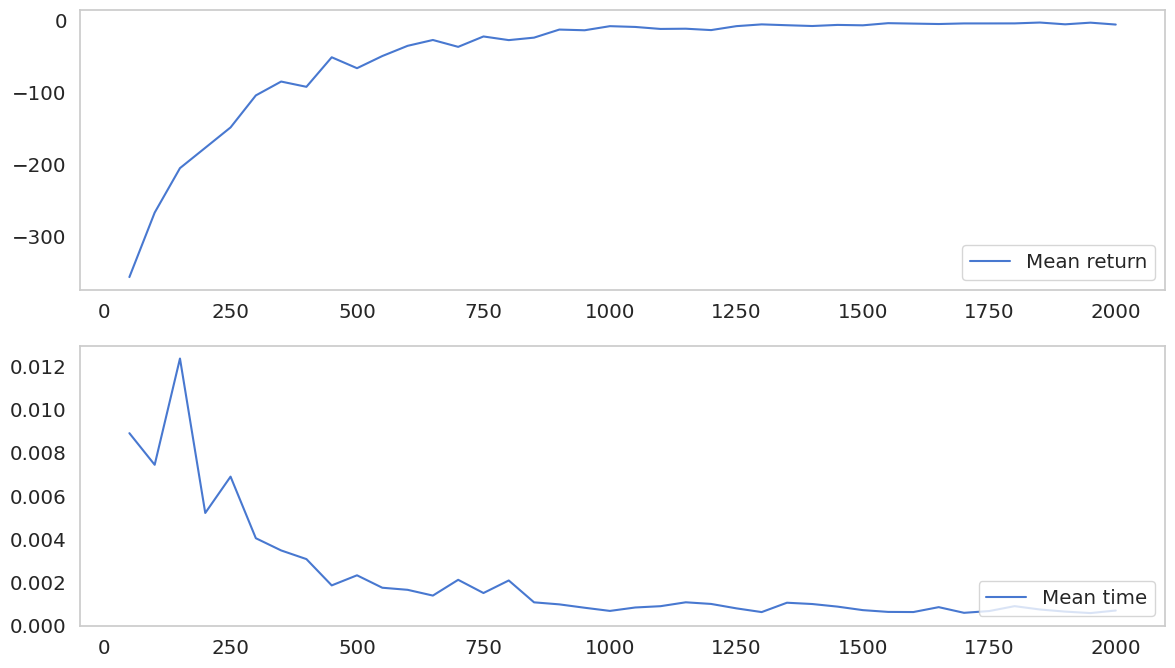

Episode: 2000, Return: 1, AvgReturn[50]: -6


In [9]:
env = gym.make('KateCab-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q, log_time_q = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

### Эксперимент 2 lr = 0.99, on_model_updates=0

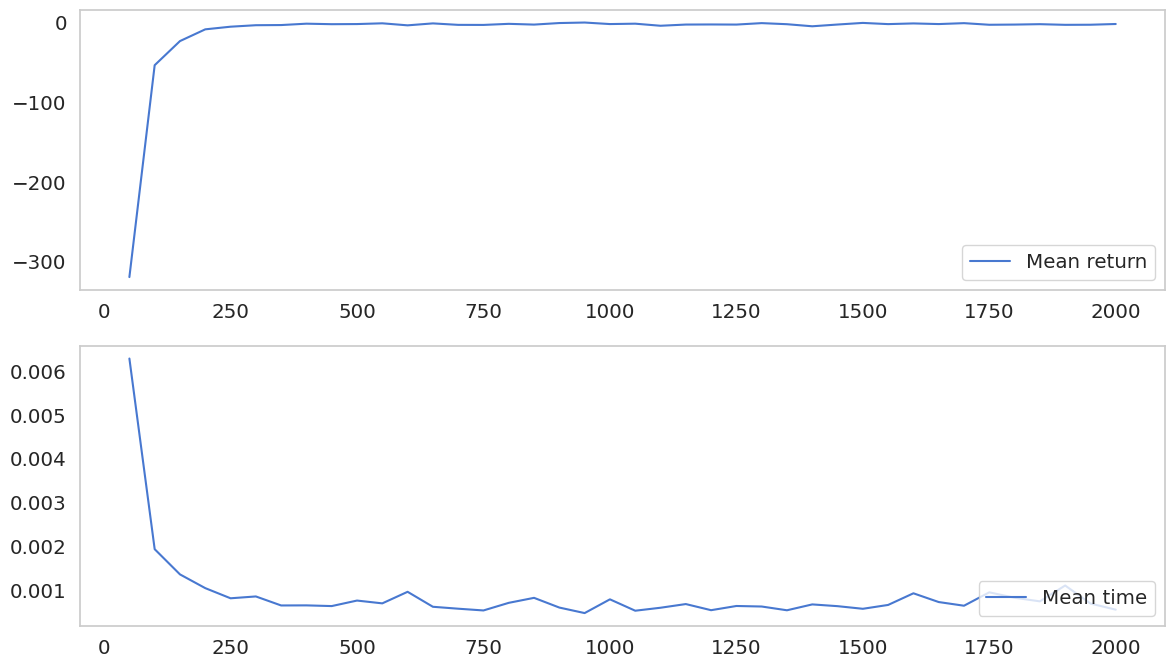

Episode: 2000, Return: -32, AvgReturn[50]: -2


In [10]:
env = gym.make('KateCab-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q2, log_time_q2 = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

### Эксперимент 3 lr = 0.99, on_model_updates=10

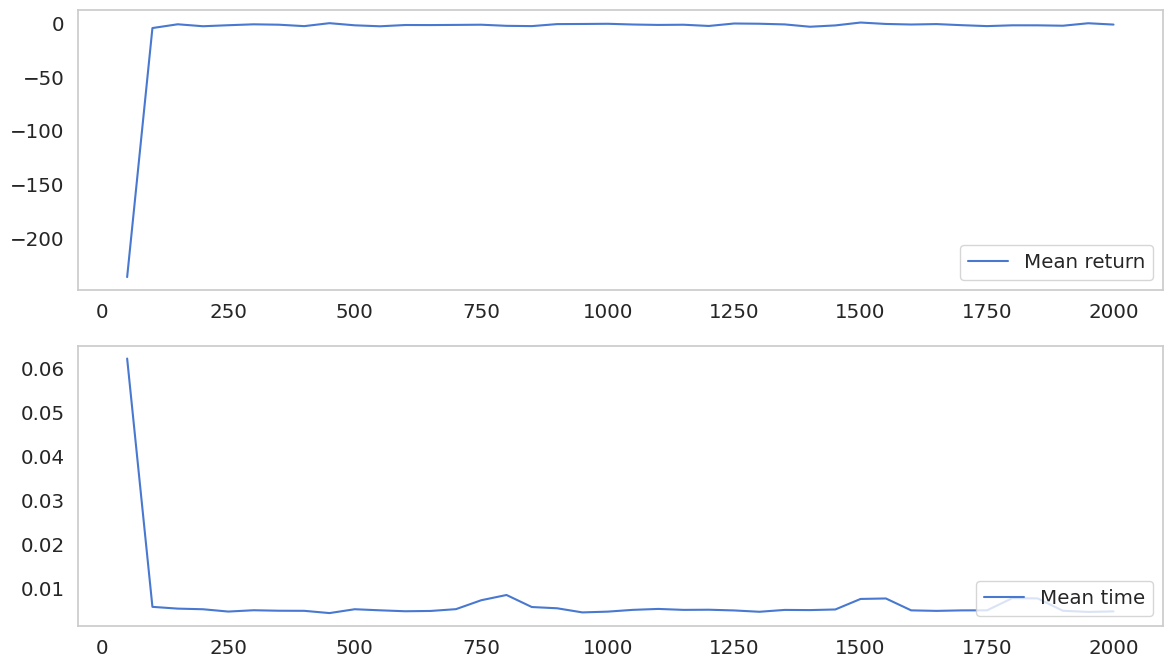

Episode: 2000, Return: -8, AvgReturn[50]: -1


In [11]:
env = gym.make('KateCab-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q, log_time_dyna_q = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

### Эксперимент 4 lr = 0.99, on_model_updates=100

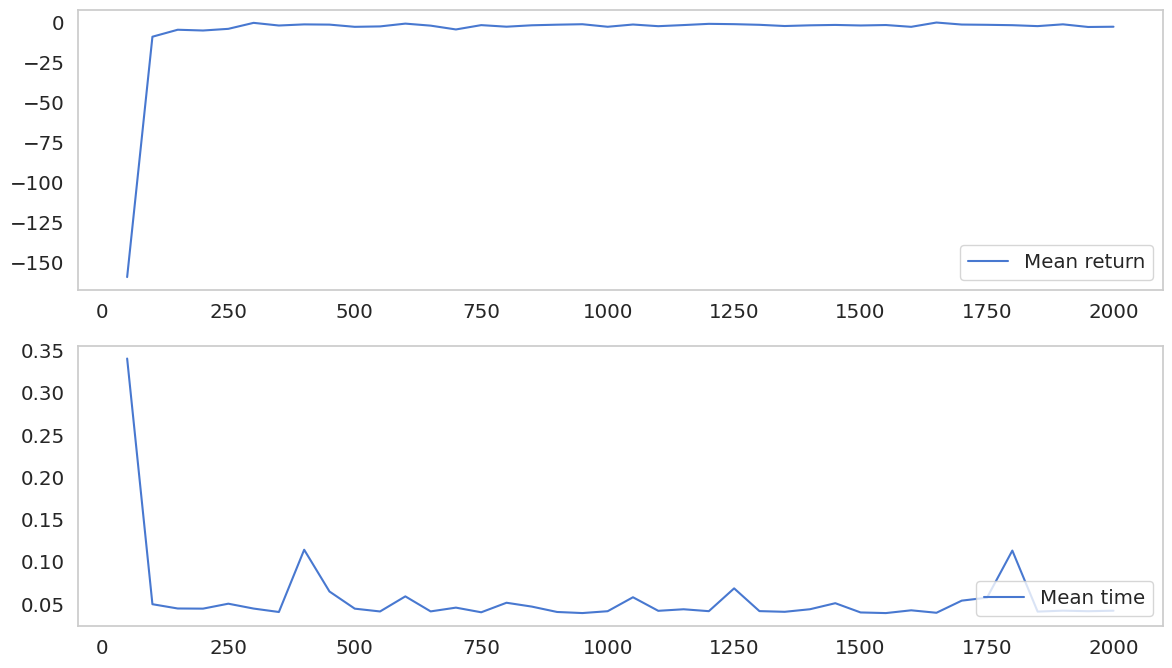

Episode: 2000, Return: -8, AvgReturn[50]: -3


In [12]:
gym.make('KateCab-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q2, log_time_dyna_q2 = train(env, agent, n_episodes=2001, on_model_updates=100, seed=seed)

### Результаты по детерминированной среде

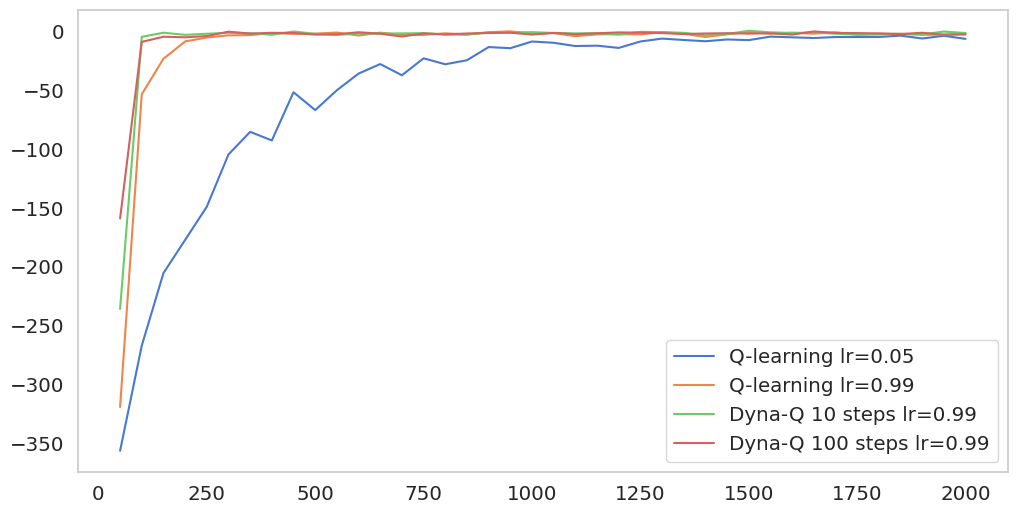

In [13]:
compare_logs([
    (log_q, 'Q-learning lr=0.05'),
    (log_q2, 'Q-learning lr=0.99'),
    (log_dyna_q, 'Dyna-Q 10 steps lr=0.99'),
    (log_dyna_q2, 'Dyna-Q 100 steps lr=0.99'),

])

Если сравнивать графики обучения (гарфики выше), то очевидно положительное влияние более высокго lr. Даже обычный Q-learning дал повышение скорости обучения агента.
Dyna-Q дала дополнительный прирост. Интересно, что разницы между 10 и 100 шагами с точки зрения прироста скрости практиески нет. Подтвердилась гипотеза об избыточности такого кол-ва искусственных данных для среды такси.

Если сравнивать алгоритмы по длительности эпизода (графики ниже), то ожидаемо - 100 доплнительных шагов потребовали болшее кол-во времени, 10 шагов практически сопоставимы с обычнм Q-learning.

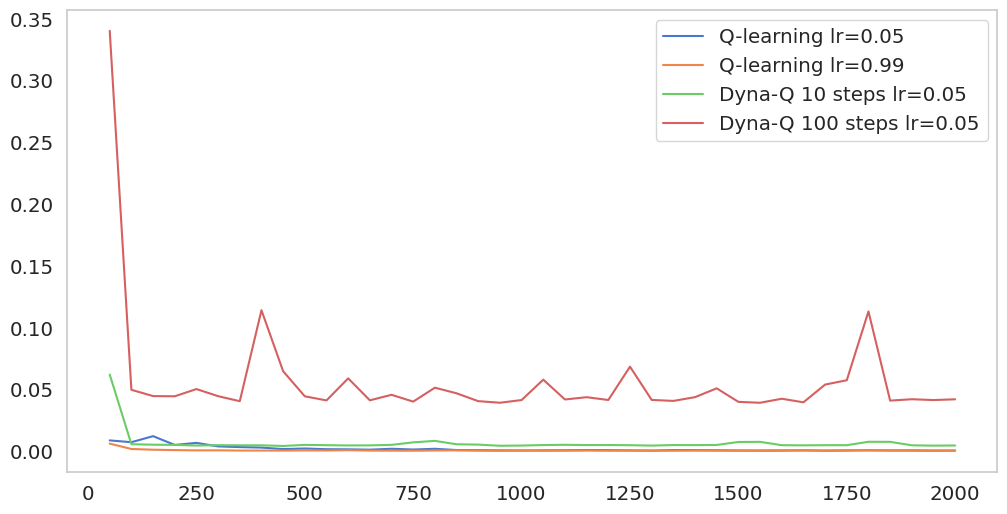

In [14]:
compare_logs([
    (log_time_q, 'Q-learning lr=0.05'),
    (log_time_q2, 'Q-learning lr=0.99'),
    (log_time_dyna_q, 'Dyna-Q 10 steps lr=0.05'),
    (log_time_dyna_q2, 'Dyna-Q 100 steps lr=0.05'),

])

## Стохастическая среда

Детерминированная среда характеризуется тем, что действие агента имеет один определенной исход. Как в предыдущей среде - выбор одного из вариантов действий имел один исход: если 0 - движение на клетку вниз, 1 - на клетку вверх и т.д. Чтобы превратить эту среду в стохастическую добавим неопредленность: при выборе одного из действий 0, 1, 2, 3 кол-во клеток, на которые будет двигаться такси будет варьироваться от 0 (вероятность 0,3), 1 - это стандартно ожидаемое действие (вероятность оставлю высокой = 0,4) и 2 - такси будет проскакивать на 2 клетки с  вероятностью  0,3.

Проведу 4 эксперимента:

1. **lr = 0.05,  on_model_updates=0** - это вариант алгоритма без Dyna-Q, обычный Q-learning. Его буду счиать baseline

2. **lr = 0.99,  on_model_updates=0** - посмотрю, насколько важен lr в этой ситуации, так как в некоторых работах предлагают для детерминированных сред использовать lr близкий к 1. Среда такси стохастична при инициализации, затем детерминирована. Не совсем понято, какой лучше использовать вариант.

3. **lr = 0.99** (выбираю лучший по итогам предыдущих экспериментов),  **on_model_updates= 10** - вносим искусственные данные. Для среды gum taxi, где может быть немного шагов, такая величина может быть оптимальна. Проверим это.

4. **lr = 0.99** (выбираю лучший по итогам предыдущих экспериментов),  **on_model_updates= 100** - вносим искусственные данные в кол-ве 100 семплов. Наверное, это слишком большое кол-во для такой среды как такси, но хочется сравнить, как в итоге это повлияет на кривую обучения.

In [22]:
MAP = [
    "+---------+",
    "|a: :A: :b|",
    "| : : : : |",
    "| :B:C: : |",
    "| : : : : |",
    "|c: :D:d: |",
    "+---------+",
]

step_numbers = [0, 1, 2]
probabilities = [0.3, 0.4, 0.3]

class KateCab_Stoch(gym.Env):
    """
    Modified Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world (a,b,c,d). When the episode starts, the taxi starts off at a random square and the passenger is at a random location.
    The taxi drive to the passenger's location, pick up the passenger, drive to the passenger's destination (another one of the four specified locations), and then drop off the passenger.
    Once the passenger is dropped off, the episode ends.

    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is the taxi), and 4 destination locations.

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move down
    - 1: move up
    - 2: move right
    - 3: move left
    - 4: pickup passenger
    - 5: dropoff passenger

    Rewards:
    There is a reward of -1 for each action and an additional reward of +10 for delievering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (a, b, c, d -destinations; A, B, C, D - passenger locations): locations for passengers and destinations

    actions:
    - 0: down
    - 1: up
    - 2: right
    - 3: left
    - 4: pickup
    - 5: dropoff

    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render_modes': ['human', 'ansi', 'rgb_array'],
                "render_fps": 4}

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0,0), (0,4), (4,0), (4,3)]
        self.passenger_locs = p_locs= [(0,2), (2,1), (2,2), (4,2)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        self.P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1 # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                random_step = random.choices(step_numbers, weights=probabilities, k=1) # вот тут стохастичность вносится!!!
                                new_row = min(row + random_step[0], max_row)
                            elif action == 1:
                                random_step = random.choices(step_numbers, weights=probabilities, k=1)# вот тут стохастичность вносится!!!
                                new_row = max(row - random_step[0], 0)
                            if action == 2:
                                random_step = random.choices(step_numbers, weights=probabilities, k=1)# вот тут стохастичность вносится!!!
                                new_col = min(col + random_step[0], max_col)
                            elif action == 3:
                                random_step = random.choices(step_numbers, weights=probabilities, k=1)# вот тут стохастичность вносится!!!
                                new_col = max(col - random_step[0], 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == p_locs[pass_idx]): # ссылка на местоположение пассажира
                                    new_pass_idx = 4
                                else: # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 10
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else: # dropoff at wrong location
                                    reward = -10

                            new_loc = (new_row, new_col)

                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            self.P[state][action].append(
                                (1.0, new_state, reward, done))
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = gym.spaces.Discrete(num_actions)
        self.observation_space = gym.spaces.Discrete(num_states)


    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        if taxi_row < 4:
            mask[0] = 1
        if taxi_row > 0:
            mask[1] = 1
        if taxi_col < 4 and self.desc[taxi_row + 1, 2 * taxi_col + 2] == b":":
            mask[2] = 1
        if taxi_col > 0 and self.desc[taxi_row + 1, 2 * taxi_col] == b":":
            mask[3] = 1
        if pass_loc < 4 and (taxi_row, taxi_col) == self.passenger_locs[pass_loc]:
            mask[4] = 1
        if pass_loc == 4 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1
        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout
        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x

        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.passenger_locs[pass_idx] # passenger location
            out[1 + pi][2 * pj + 1] = gym.utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = gym.utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = gym.utils.colorize(out[1 + di][2 * dj + 1], 'magenta')

        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Down", "Up", "Right", "Left", "Pickup", "Dropoff"][self.lastaction]))
        else: outfile.write("\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()

register(
    id='KateCab_Stoch-v0',
    entry_point=f"{__name__}:KateCab_Stoch",
    max_episode_steps=250,
)

In [23]:
env = gym.make('KateCab_Stoch-v0', new_step_api=True)
env.reset()
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|a: :A: :b|
| : : : : |
| :B:C: : |
| : : : : |
|c: :D:d: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


### Эксперимент 1 lr = 0.05,  on_model_updates=0

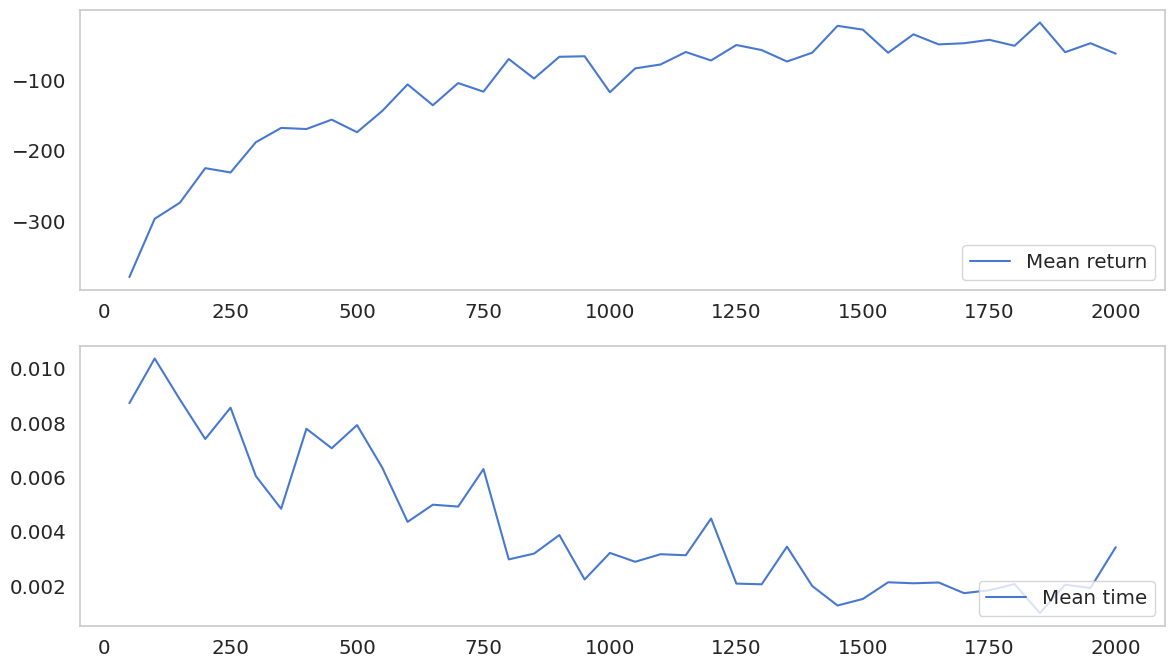

Episode: 2000, Return: -52, AvgReturn[50]: -62


In [26]:
env = gym.make('KateCab_Stoch-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q_s, log_time_q_s = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

### Эксперимент 2 lr = 0.99,  on_model_updates=0

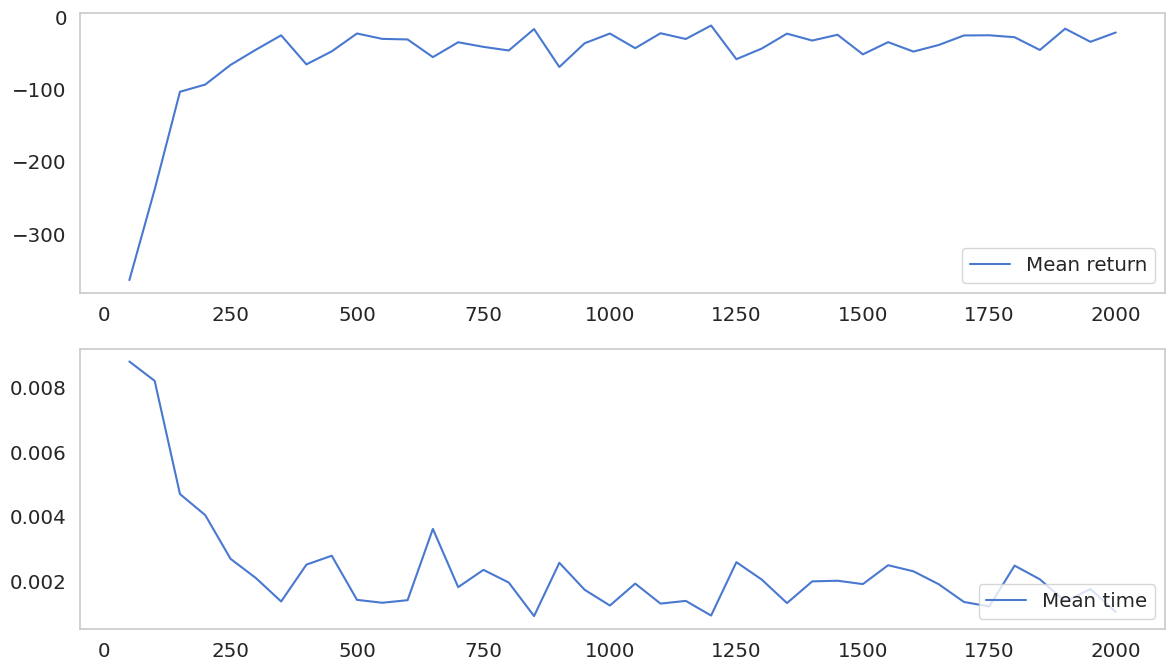

Episode: 2000, Return: -10, AvgReturn[50]: -21


In [27]:
env = gym.make('KateCab_Stoch-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q_s2, log_time_q_s2 = train(env, agent, n_episodes=2001, on_model_updates=0, seed=seed, show_progress_schedule=50)

А вот получилось конечно странно, результаты стохастической среды все равно лучше при lr = 0.99, чем при lr = 0.05. Наверное, среда все-таки условно-стохастической получилась. Хотя агент на том же кол-ве эпизодов стал учиться хуже.


### Эксперимент 3 lr = 0.99,  on_model_updates=10

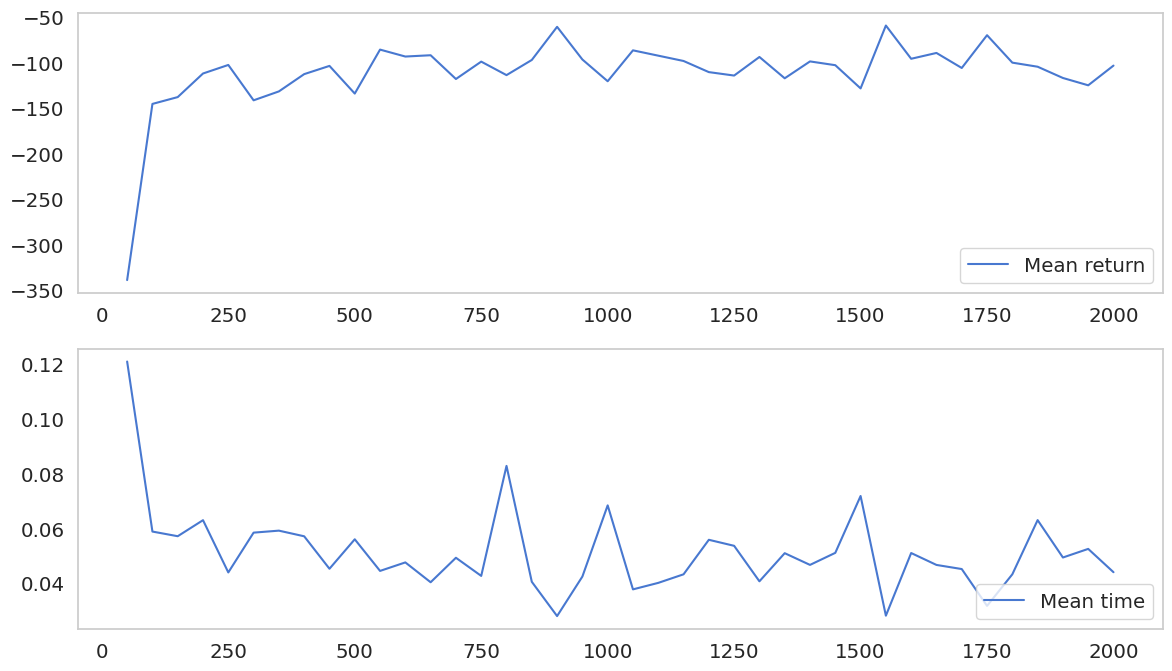

Episode: 2000, Return: 2, AvgReturn[50]: -104


In [28]:
env = gym.make('KateCab_Stoch-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q_s, log_time_dyna_q_s = train(env, agent, n_episodes=2001, on_model_updates=10, seed=seed)

### Эксперимент 4 lr = 0.99,  on_model_updates=100

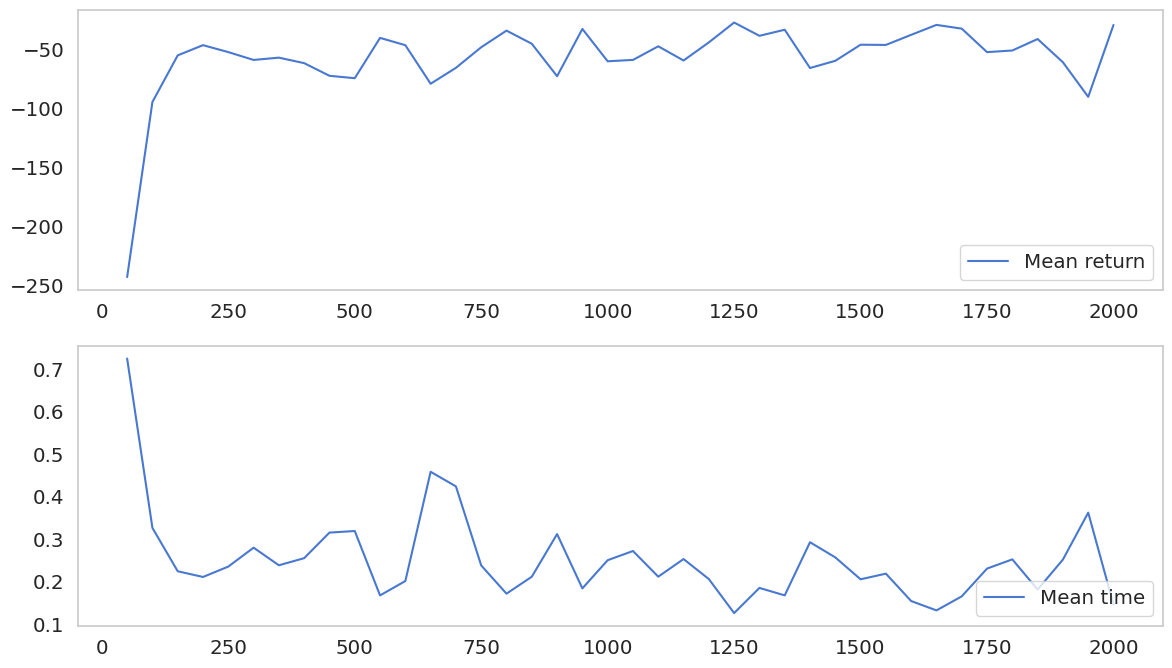

Episode: 2000, Return: -9, AvgReturn[50]: -29


In [30]:
env = gym.make('KateCab_Stoch-v0', new_step_api=True)
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.99, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q2_s, log_time_dyna_q2_s = train(env, agent, n_episodes=2001, on_model_updates=100, seed=seed)

## Сравнение экспериментов во обеих средах

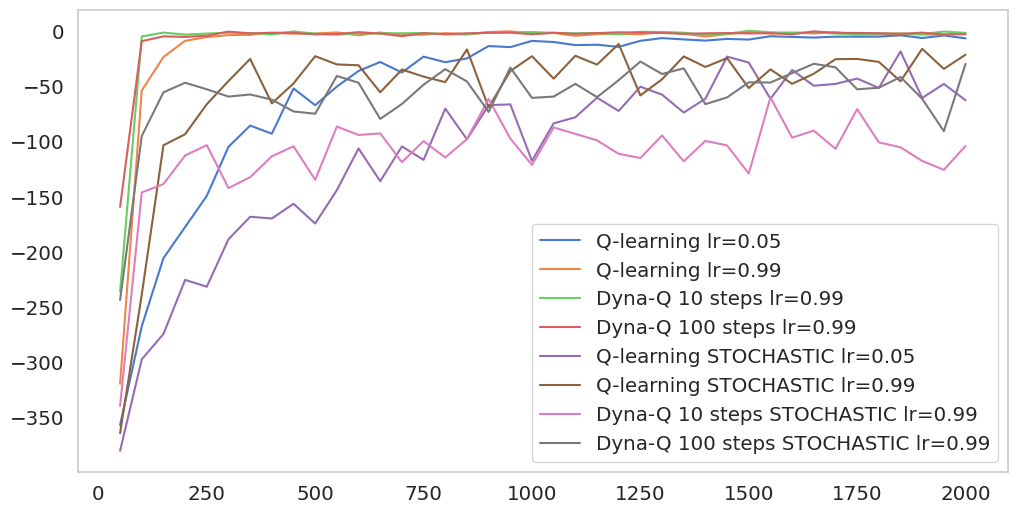

In [31]:
compare_logs([
    (log_q, 'Q-learning lr=0.05'),
    (log_q2, 'Q-learning lr=0.99'),
    (log_dyna_q, 'Dyna-Q 10 steps lr=0.99'),
    (log_dyna_q2, 'Dyna-Q 100 steps lr=0.99'),
    (log_q_s, 'Q-learning STOCHASTIC lr=0.05'),
    (log_q_s2, 'Q-learning STOCHASTIC lr=0.99'),
    (log_dyna_q_s, 'Dyna-Q 10 steps STOCHASTIC lr=0.99'),
    (log_dyna_q2_s, 'Dyna-Q 100 steps STOCHASTIC lr=0.99'),
])

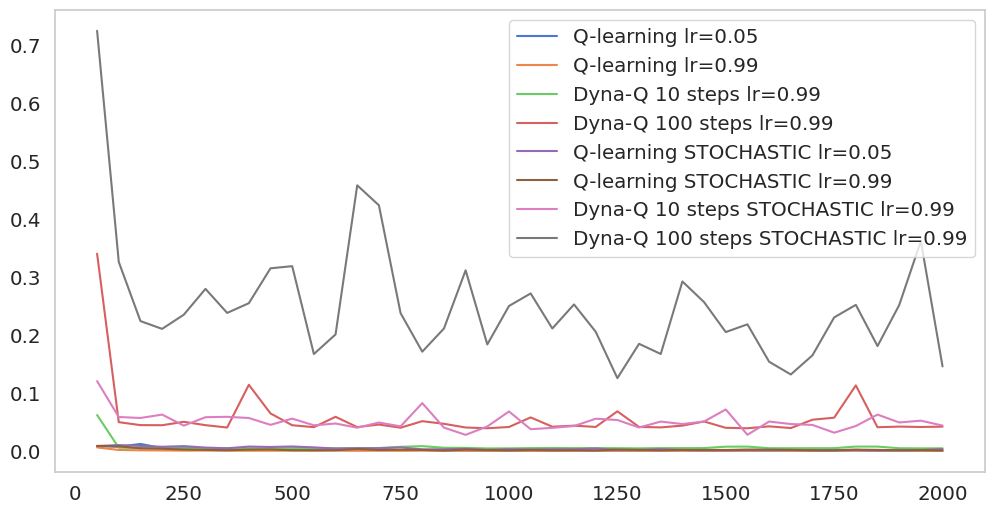

In [32]:
compare_logs([
    (log_time_q, 'Q-learning lr=0.05'),
    (log_time_q2, 'Q-learning lr=0.99'),
    (log_time_dyna_q, 'Dyna-Q 10 steps lr=0.99'),
    (log_time_dyna_q2, 'Dyna-Q 100 steps lr=0.99'),
    (log_time_q_s, 'Q-learning STOCHASTIC lr=0.05'),
    (log_time_q_s2, 'Q-learning STOCHASTIC lr=0.99'),
    (log_time_dyna_q_s, 'Dyna-Q 10 steps STOCHASTIC lr=0.99'),
    (log_time_dyna_q2_s, 'Dyna-Q 100 steps STOCHASTIC lr=0.99'),

])

# Финальные выводы

Результаты всех 6-ми экспериментов показаны на графиках выше: изменение среднего суммарного вознаграждения и среднего суммарного времени на эпизод.

Интересный эффект произошел от смены lr - более высокий lr дает лучший результат в обеих средах.

Использование Dyna-Q и в стохастической среде дало более быстрое обучение, то в целом качество не повысило.

